Importing the statements that are required for the models

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [4]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Split into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)


170498071/170498071 [==============================] - 2s 0us/step


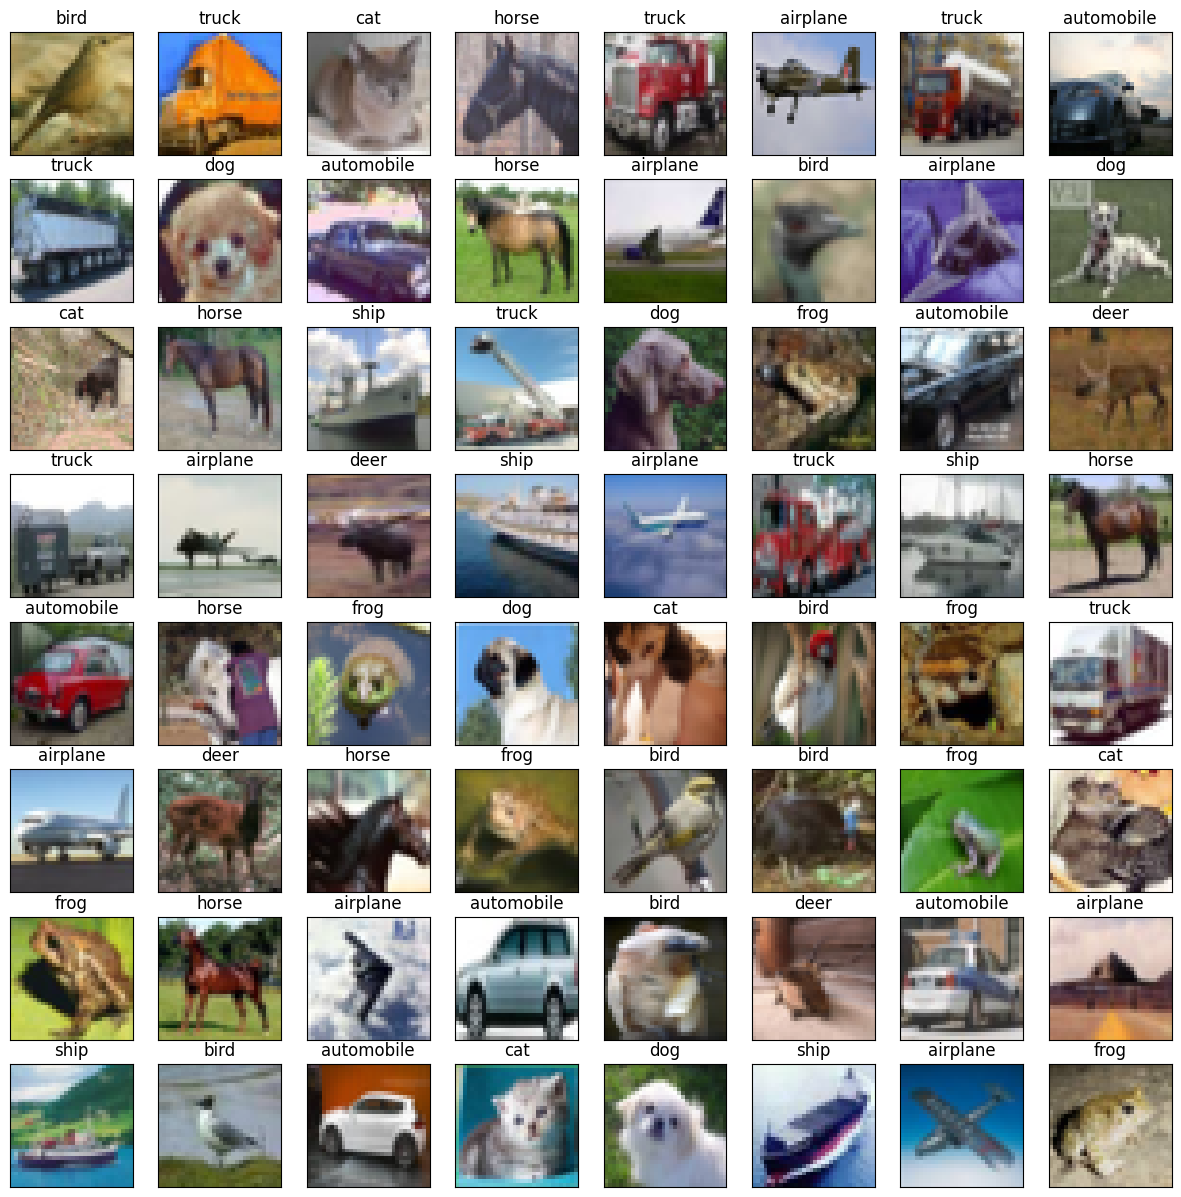

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(15,15))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(X_train[i])

    plt.title(class_names[int(y_train[i][0])], fontsize=12)

plt.show()

In [6]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

X_train /= 255.0
X_test  /= 255.0
X_valid /= 255.0

# One-hot encoding of labels
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)


Image sizes before reshaping

In [7]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 10)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 10)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 10)


In [8]:
# Resize inputs for the models
X_train_xception = tf.image.resize(X_train, [71, 71])
X_valid_xception = tf.image.resize(X_valid, [71, 71])
X_test_xception  = tf.image.resize(X_test, [71, 71])

X_train_inception = tf.image.resize(X_train, [75, 75])
X_valid_inception = tf.image.resize(X_valid, [75, 75])
X_test_inception  = tf.image.resize(X_test, [75, 75])


Image sizes after reshaping

In [9]:
print('Xception_Train Images Shape:      ', X_train_xception.shape)
print('inception_Train Images Shape:     ', X_train_inception.shape)
print('Train Labels Shape:               ', y_train.shape)

print('\nValidation_inception Images Shape:', X_valid_inception.shape)
print('Validation_xception Image Shape:  ', X_valid_xception.shape)
print('Validation Labels Shape:          ', y_valid.shape)

print('\nTest_inception Images Shape:      ', X_test_inception.shape)
print('Test_xception Image Shape:        ', X_test_xception.shape)
print('Test Labels Shape:                ', y_test.shape)

Xception_Train Images Shape:       (45000, 71, 71, 3)
inception_Train Images Shape:      (45000, 75, 75, 3)
Train Labels Shape:                (45000, 10)

Validation_inception Images Shape: (5000, 75, 75, 3)
Validation_xception Image Shape:   (5000, 71, 71, 3)
Validation Labels Shape:           (5000, 10)

Test_inception Images Shape:       (10000, 75, 75, 3)
Test_xception Image Shape:         (10000, 71, 71, 3)
Test Labels Shape:                 (10000, 10)


Data augumentation

In [10]:
batch_size = 64
# Data Generators (with batch size)
train_generator_xception = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
).flow(X_train_xception, y_train, batch_size=batch_size)

train_generator_inception = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
).flow(X_train_inception, y_train, batch_size=batch_size)

# Define combined generators
def combined_generator(gen1, gen2):
    while True:
        batch1 = next(gen1)
        batch2 = next(gen2)
        yield (batch1[0], batch2[0]), batch1[1]  # Match the labels


Inception & Xception model

In [11]:
# Load pre-trained Xception model
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(71, 71, 3))
xception_output = GlobalAveragePooling2D()(xception_base.output)

# Load pre-trained InceptionV3 model
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
inception_output = GlobalAveragePooling2D()(inception_base.output)

# Concatenate the outputs of both models
merged_output = concatenate([xception_output, inception_output])

# Add fully connected layers on top of the combined models
x = Dense(512, activation='relu')(merged_output)  # Reduced size for less overfitting
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# Define final model
model = Model(inputs=[xception_base.input, inception_base.input], outputs=predictions)

# Freeze base model layers
for layer in xception_base.layers:
    layer.trainable = False
for layer in inception_base.layers:
    layer.trainable = False

# Unfreeze last few layers
for layer in xception_base.layers[-30:]:  # Unfreeze last 30 layers
    layer.trainable = True
for layer in inception_base.layers[-30:]:
    layer.trainable = True

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

87910968/87910968 [==============================] - 0s 0us/step


Model fitting phase

In [12]:
# Fit the model using the combined generator
epochs = 20
batch_size = 64
steps_per_epoch = len(X_train) // batch_size  # Total steps per epoch

# Train the model
model.fit(
    combined_generator(train_generator_xception, train_generator_inception),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=([X_valid_xception, X_valid_inception], y_valid),
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/20
703/703 [==============================] - 265s 363ms/step - loss: 1.0655 - accuracy: 0.6360 - val_loss: 0.5388 - val_accuracy: 0.8138 - lr: 1.0000e-04
Epoch 2/20
703/703 [==============================] - 250s 357ms/step - loss: 0.6106 - accuracy: 0.7930 - val_loss: 0.4632 - val_accuracy: 0.8418 - lr: 1.0000e-04
Epoch 3/20
703/703 [==============================] - 250s 356ms/step - loss: 0.5053 - accuracy: 0.8293 - val_loss: 0.4428 - val_accuracy: 0.8532 - lr: 1.0000e-04
Epoch 4/20
703/703 [==============================] - 248s 352ms/step - loss: 0.4371 - accuracy: 0.8494 - val_loss: 0.4215 - val_accuracy: 0.8594 - lr: 1.0000e-04
Epoch 5/20
703/703 [==============================] - 247s 351ms/step - loss: 0.3851 - accuracy: 0.8673 - val_loss: 0.4091 - val_accuracy: 0.8650 - lr: 1.0000e-04
Epoch 6/20
703/703 [==============================] - 243s 346ms/step - loss: 0.3449 - accuracy: 0.8815 - val_loss: 0.3937 - val_accuracy: 0.8728 - lr: 1.0000e-04
Epoch 7/20
703/703 [==

In [13]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate([X_test_xception, X_test_inception], y_test, verbose=1)

print(f'\nTest Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

313/313 [==============================] - 30s 95ms/step - loss: 0.4235 - accuracy: 0.8658

Test Accuracy: 0.8658
Test Loss: 0.4235


In [14]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.0 MB/s eta 0:00:00


Interface Loading

In [15]:
import gradio as gr
import cv2
import numpy as np

# Function to preprocess the image for both Xception and InceptionV3
def preprocess_image(image):
    image_resized_xception = cv2.resize(image, (71, 71))
    image_resized_inception = cv2.resize(image, (75, 75))

    # Normalize the images
    image_resized_xception = image_resized_xception.astype('float32') / 255.0
    image_resized_inception = image_resized_inception.astype('float32') / 255.0

    # Expand dimensions to match the batch size expected by the model
    image_resized_xception = np.expand_dims(image_resized_xception, axis=0)
    image_resized_inception = np.expand_dims(image_resized_inception, axis=0)

    return [image_resized_xception, image_resized_inception]

# Function to make predictions
def predict(image):
    preprocessed_images = preprocess_image(image)

    # Get model predictions
    predictions = model.predict(preprocessed_images)

    # CIFAR-10 class labels
    class_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    # Return the class label with the highest probability
    predicted_class = class_labels[np.argmax(predictions)]

    return predicted_class

# Create the Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(),
    outputs="text",
    title="CIFAR-10 Image Classification",
    description="Upload an image of one of the CIFAR-10 classes (Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck) to get a prediction."
)

# Launch the Gradio interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b0da06ee8edd0fa298.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
